# Digits classification using a multi-layer perceptron (MLP)

A multilayer perceptron (MLP) is a feedforward artificial neural network model that maps sets of input data onto a set of appropriate outputs. An MLP consists of multiple layers of nodes in a directed graph, with each layer fully connected to the next one. Except for the input nodes, each node is a neuron (or processing element) with a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training the network. MLP is a modification of the standard linear perceptron and can distinguish data that are not linearly separable.

A multilayer perceptron is a logistic regressor where
instead of feeding the input to the logistic regression you insert a
intermediate layer, called the hidden layer, that has a nonlinear
activation function (usually tanh or sigmoid) . One can use many such
hidden layers making the architecture deep. The tutorial will also tackle
the problem of MNIST digit classification.

A good reference for machine learning or MLP is the famous textbook [Pattern Recognition and Machine Learning" by Christopher M. Bishop, section 5](https://books.google.de/books/about/Pattern_Recognition_and_Machine_Learning.html?id=kTNoQgAACAAJ&source=kp_cover&redir_esc=y)


In [1]:
import os
import sys
sys.path.append('/scripts/')
import timeit

import numpy
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T
DATA_PREFIX = '/data/'

from logistic_sgd import LogisticRegression, load_data

# Having a glance at the data

In this example we use written digit recognition. The MNIST database of handwritten digits has a training set of 50,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. Essentially, the data consists of image patches of size $28 x 28$ and their corresponding label $[0-9]$.

In [2]:
# load the dataset
datasets = load_data(DATA_PREFIX+'/mnist/mnist.pkl.gz')

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]



... loading data


(50000, 784)
The label is: 5
Min: 0.0 | Max: 0.99609375


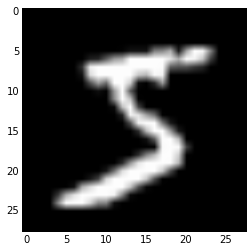

In [3]:
# Now let's have a look how the data looks like. Essentially it is a matrix with number of columns corresponding to 
# flattened image size(=28x28) and number of rows equal to number of samples.

# So far it is just symbolic, now we have to get the actual data
trainX = train_set_x.eval()
trainY = train_set_y.eval()
print(trainX.shape)

# we want to look at index 0
idx = 0
# Plot the first image in the training set
plt.imshow(trainX[idx,:].reshape((28,28)),cmap=plt.get_cmap('gray'))
# What's the corresponding label?
print("The label is: "+str(trainY[idx]))

# It is important to look at the range of the data, often normalization (range [0,1]) is required
print("Min: "+str(numpy.min(trainX[:]))+" | Max: "+str(numpy.max(trainX[:])))

# Hidden layer for the MLP
The hidden layer consists of three elements. A weight matrix $W$, a bias element $b$ and a non-linear activation e.g. $tanh$ function. Given input $x$ is essentially just computed $tanh(Wx+b)$.

In [4]:
class HiddenLayer(object):
    def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                 activation=T.tanh):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.dmatrix
        :param input: a symbolic tensor of shape (n_examples, n_in)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: theano.Op or function
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input = input
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # for tanh activation function
        # the output of uniform if converted using asarray to dtype
        # theano.config.floatX so that the code is runable on GPU
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        if W is None:
            W_values = numpy.asarray(
                rng.uniform(
                    low=-numpy.sqrt(6. / (n_in + n_out)),
                    high=numpy.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == theano.tensor.nnet.sigmoid:
                W_values *= 4

            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b

        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )
        # parameters of the model
        self.params = [self.W, self.b]

# MLP definition
Here we define a MLP. We connect a hidden layer with a logistic regression layer. 
To make it deep we could stack up multiple hidden layers like a pancake. 
The end of the network remains the same, a logistic regression layer (for classification)


### Regularization

In machine learning we train our model from data, trying to prepare it to do well on new examples, not the ones it has already seen. A typical problem is overfitting. That is a learnt statistical model describes random error or noise instead of the underlying relationship. Overfitting generally occurs when a model is excessively complex, such as having too many parameters relative to the number of observations. A model that has been overfit will generally have poor predictive performance, as it can exaggerate minor fluctuations in the data. A way to combat overfitting is through regularization. There are several techniques for regularization. Here we use L1/L2 regularization. These terms are simply added to the cost. Each term is associated with a weight factor to adjust the relative importance. 

In principle, adding a regularization term to the loss will encourage smooth network mappings in a neural network (e.g. by penalizing large values of the parameters, which decreases the amount of nonlinearity that the network models). Minimizing the sum of the cost and the regularization terms will in theory correspond to finding the right trade-off between the fit to the training data and the “generality” of the solution that is found. To follow Occam’s razor principle, this minimization should find us the simplest solution (as measured by our simplicity criterion) that fits the training data.

L2 punishes large parameters, whereas L1 enforces sparsity.


### Early stopping

Early-stopping combats overfitting by monitoring the model’s performance on a validation set. A validation set is a set of examples that we never use for gradient descent, but which is also not a part of the test set. The validation examples are considered to be representative of future test examples. We can use them during training because they are not part of the test set. If the model’s performance ceases to improve sufficiently on the validation set, or even degrades with further optimization, then the heuristic implemented here gives up on much further optimization.
The choice of when to stop is a judgement call and a few heuristics exist, but these tutorials will make use of a strategy based on a geometrically increasing amount of patience.


### Initialization
It is a very important and not trivial, because it is necessary that signals reach deep into the network.

* If the weights in a network start too small, then the signal shrinks as it passes through each layer until it’s too tiny to be useful.

* If the weights in a network start too large, then the signal grows as it passes through each layer until it’s too massive to be useful.

In [5]:
class MLP(object):
    """Multi-Layer Perceptron Class

    A multilayer perceptron is a feedforward artificial neural network model
    that has one layer or more of hidden units and nonlinear activations.
    Intermediate layers usually have as activation function tanh or the
    sigmoid function (defined here by a ``HiddenLayer`` class)  while the
    top layer is a softmax layer (defined here by a ``LogisticRegression``
    class).
    """

    def __init__(self, rng, input, n_in, n_hidden, n_out):
        """Initialize the parameters for the multilayer perceptron

        :type rng: numpy.random.RandomState
        :param rng: a random number generator used to initialize weights

        :type input: theano.tensor.TensorType
        :param input: symbolic variable that describes the input of the
        architecture (one minibatch)

        :type n_in: int
        :param n_in: number of input units, the dimension of the space in
        which the datapoints lie

        :type n_hidden: int
        :param n_hidden: number of hidden units

        :type n_out: int
        :param n_out: number of output units, the dimension of the space in
        which the labels lie

        """

        # Since we are dealing with a one hidden layer MLP, this will translate
        # into a HiddenLayer with a tanh activation function connected to the
        # LogisticRegression layer; the activation function can be replaced by
        # sigmoid or any other nonlinear function
        self.hiddenLayer = HiddenLayer(
            rng=rng,
            input=input,
            n_in=n_in,
            n_out=n_hidden,
            activation=T.tanh
        )

        # The logistic regression layer gets as input the hidden units
        # of the hidden layer.
        self.logRegressionLayer = LogisticRegression(
            input=self.hiddenLayer.output,
            n_in=n_hidden,
            n_out=n_out
        )
        # end-snippet-2 start-snippet-3
        # L1 norm ; one regularization option is to enforce L1 norm to
        # be small
        self.L1 = (
            abs(self.hiddenLayer.W).sum()
            + abs(self.logRegressionLayer.W).sum()
        )

        # square of L2 norm ; one regularization option is to enforce
        # square of L2 norm to be small
        self.L2_sqr = (
            (self.hiddenLayer.W ** 2).sum()
            + (self.logRegressionLayer.W ** 2).sum()
        )

        # negative log likelihood of the MLP is given by the negative
        # log likelihood of the output of the model, computed in the
        # logistic regression layer
        self.negative_log_likelihood = (
            self.logRegressionLayer.negative_log_likelihood
        )
        # same holds for the function computing the number of errors
        self.errors = self.logRegressionLayer.errors

        # the parameters of the model are the parameters of the two layer it is
        # made out of
        self.params = self.hiddenLayer.params + self.logRegressionLayer.params
        # end-snippet-3

        # keep track of model input
        self.input = input

In [6]:
def test_mlp(param):
    """
    Demonstrate stochastic gradient descent optimization for a multilayer
    perceptron

    This is demonstrated on MNIST.

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
    gradient

    :type L1_reg: float
    :param L1_reg: L1-norm's weight when added to the cost (see
    regularization)

    :type L2_reg: float
    :param L2_reg: L2-norm's weight when added to the cost (see
    regularization)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

    :type dataset: string
    :param dataset: the path of the MNIST dataset file from
                 http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz


   """
    datasets = load_data(param['data'])
    
    batch_size = param['batch_size']
    n_hidden = param['nhidden']
    learning_rate = param['lr']
    L1_reg = param['L1_reg']
    L2_reg = param['L2_reg']
    n_epochs = param['nepochs']

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]

    # compute number of minibatches for training, validation and testing
    n_train_batches = int(train_set_x.get_value(borrow=True).shape[0] / batch_size)
    n_valid_batches = int(valid_set_x.get_value(borrow=True).shape[0] / batch_size)
    n_test_batches = int(test_set_x.get_value(borrow=True).shape[0] / batch_size)

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print('... building the model')

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch
    x = T.matrix('x')  # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    rng = numpy.random.RandomState(1234)

    # construct the MLP class
    classifier = MLP(
        rng=rng,
        input=x,
        n_in=28 * 28,
        n_hidden=n_hidden,
        n_out=10
    )

    # start-snippet-4
    # the cost we minimize during training is the negative log likelihood of
    # the model plus the regularization terms (L1 and L2); cost is expressed
    # here symbolically
    cost = (
        classifier.negative_log_likelihood(y)
        + L1_reg * classifier.L1
        + L2_reg * classifier.L2_sqr
    )
    # end-snippet-4

    # compiling a Theano function that computes the mistakes that are made
    # by the model on a minibatch
    test_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: test_set_x[index * batch_size:(index + 1) * batch_size],
            y: test_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        inputs=[index],
        outputs=classifier.errors(y),
        givens={
            x: valid_set_x[index * batch_size:(index + 1) * batch_size],
            y: valid_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

    # start-snippet-5
    # compute the gradient of cost with respect to theta (sotred in params)
    # the resulting gradients will be stored in a list gparams
    gparams = [T.grad(cost, param) for param in classifier.params]

    # specify how to update the parameters of the model as a list of
    # (variable, update expression) pairs

    # given two lists of the same length, A = [a1, a2, a3, a4] and
    # B = [b1, b2, b3, b4], zip generates a list C of same size, where each
    # element is a pair formed from the two lists :
    #    C = [(a1, b1), (a2, b2), (a3, b3), (a4, b4)]
    updates = [
        (param, param - learning_rate * gparam)
        for param, gparam in zip(classifier.params, gparams)
    ]

    # compiling a Theano function `train_model` that returns the cost, but
    # in the same time updates the parameter of the model based on the rules
    # defined in `updates`
    train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    # end-snippet-5

    ###############
    # TRAIN MODEL #
    ###############
    print('... training')

    # early-stopping parameters
    patience = 10000  # look as this many examples regardless
    patience_increase = 2  # wait this much longer when a new best is
                           # found
    improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
    validation_frequency = min(n_train_batches, patience / 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = timeit.default_timer()

    epoch = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            minibatch_avg_cost = train_model(minibatch_index)
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i) for i
                                     in range(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)

                print(
                    'epoch %i, minibatch %i/%i, validation error %f %%' %
                    (
                        epoch,
                        minibatch_index + 1,
                        n_train_batches,
                        this_validation_loss * 100.
                    )
                )
                
                # Early stopping
                # Here we do some model checking. We use the validation set to evaluate the model.
                # If we notice a substantial drop in the loss, we test the performance on the test set.
                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:
                    #improve patience if loss improvement is good enough
                    if (
                        this_validation_loss < best_validation_loss *
                        improvement_threshold
                    ):
                        patience = max(patience, iter * patience_increase)

                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = [test_model(i) for i
                                   in range(n_test_batches)]
                    test_score = numpy.mean(test_losses)

                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.),flush=True)

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print(('Optimization complete. Best validation score of %f %% '
           'obtained at iteration %i, with test performance %f %%') %
          (best_validation_loss * 100., best_iter + 1, test_score * 100.))



In [7]:
param = {
    'data': DATA_PREFIX+'/mnist/mnist.pkl.gz',
    'lr': 0.01,
    'L1_reg': 0.00,
    'L2_reg': 0.0001,
    'batch_size': 20,
    # number of words in the context window
    'nhidden': 50,
    'nepochs': 1000}

test_mlp(param)

... loading data
... building the model
... training
epoch 1, minibatch 2500/2500, validation error 10.770000 %
     epoch 1, minibatch 2500/2500, test error of best model 11.520000 %
epoch 2, minibatch 2500/2500, validation error 8.870000 %
     epoch 2, minibatch 2500/2500, test error of best model 9.200000 %
epoch 3, minibatch 2500/2500, validation error 7.930000 %
     epoch 3, minibatch 2500/2500, test error of best model 8.120000 %
epoch 4, minibatch 2500/2500, validation error 7.340000 %
     epoch 4, minibatch 2500/2500, test error of best model 7.490000 %
epoch 5, minibatch 2500/2500, validation error 6.740000 %
     epoch 5, minibatch 2500/2500, test error of best model 6.960000 %
epoch 6, minibatch 2500/2500, validation error 6.220000 %
     epoch 6, minibatch 2500/2500, test error of best model 6.500000 %
epoch 7, minibatch 2500/2500, validation error 5.770000 %
     epoch 7, minibatch 2500/2500, test error of best model 6.190000 %
epoch 8, minibatch 2500/2500, validation e